In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
import mne
import glob
import time
import datetime
from params import *

In [3]:
subject = 'S1'

In [18]:
rows = []
for subject in subjects:
    hypno_ia = pd.read_excel(f'../hypnos/hypno_{subject}.xlsx', index_col = 0)['str'].values
    hypno_human = pd.read_csv(f'../autres/light_hypnos/Hypno{subject}.txt', sep = '\t', header = None)[2].values
    if hypno_ia.size == hypno_human.size:
        problem = '-'
    else:
        problem = 'MISMATCH'
    rows.append([subject, hypno_ia.size, hypno_human.size, problem])
hypnos = pd.DataFrame(rows, columns = ['sub','ia n epochs','human n epochs', 'problem ?'])
hypnos.to_excel('../autres/mismatch_hypnogrammes.xlsx')

In [19]:
hypnos

,sub,ia n epochs,human n epochs,problem ?
0,S1,1059,1072,MISMATCH
1,S2,1133,1133,-
2,S3,1197,1197,-
3,S4,1103,1103,-
4,S5,1111,1111,-
5,S6,1025,1025,-
6,S7,1227,1227,-
7,S8,480,940,MISMATCH
8,S9,1293,1294,MISMATCH
9,S10,1073,1073,-


In [5]:
def get_stage_duration(sleep_stats, subject, stage):
    return sleep_stats.set_index('subject').loc[subject, stage]

In [18]:
sleep_stats = pd.read_excel(f'../subject_characteristics/global_sleep_stats.xlsx', index_col = 0)
rows = []
evs = ['spindles','slowwaves']
for ev in evs:
    for sub in subjects:
        ev_masto = pd.read_excel(f'../event_detection/{sub}_{ev}_reref.xlsx', index_col = 0)
        if ev == 'spindles':
            ev_bipol = pd.read_excel(f'../event_detection/{sub}_spindles.xlsx', index_col = 0)
        elif ev == 'slowwaves':
            ev_bipol = pd.read_excel(f'../event_detection/{sub}_slowwaves_bipol.xlsx', index_col = 0)
        modes = {'bipol':ev_bipol, 'masto':ev_masto}
        for mode in modes.keys():
            df = modes[mode]
            n_ev_total = df.shape[0]
            for stage in ['N2','N3']:
                df_stage = df[df['Stage_Letter'] == stage]
                n_ev_stage = df_stage.shape[0]
                stage_duration = get_stage_duration(sleep_stats, sub, stage)
                density_by_stage = n_ev_stage / stage_duration
                for chan in df_stage['Channel'].unique():
                    df_stage_chan = df_stage[df_stage['Channel'] == chan]
                    n_ev_stage_chan = df_stage_chan.shape[0]
                    density_by_stage_by_chan = n_ev_stage_chan / stage_duration

                    row = [ev ,sub, mode, stage, chan, n_ev_total, stage_duration, n_ev_stage, density_by_stage, n_ev_stage_chan, density_by_stage_by_chan ]
                    rows.append(row)
df_spindles_comparison = pd.DataFrame(rows, columns = ['event','subject','mode','stage','chan','n_events_total','stage_duration','n_events_stage','density_by_stage','n_events_stage_chan','density_by_stage_by_chan'])

In [19]:
df_spindles_comparison

,event,subject,mode,stage,chan,n_events_total,stage_duration,n_events_stage,density_by_stage,n_events_stage_chan,density_by_stage_by_chan
0,spindles,S1,bipol,N2,Fp2-C4,4988,199.0,2617,13.150754,547,2.748744
1,spindles,S1,bipol,N2,Fz-Cz,4988,199.0,2617,13.150754,535,2.688442
2,spindles,S1,bipol,N2,Fp1-C3,4988,199.0,2617,13.150754,578,2.904523
3,spindles,S1,bipol,N2,C4-T4,4988,199.0,2617,13.150754,449,2.256281
4,spindles,S1,bipol,N2,C3-T3,4988,199.0,2617,13.150754,441,2.216080
...,...,...,...,...,...,...,...,...,...,...,...
1225,slowwaves,S20,masto,N3,T4,4064,88.0,3458,39.295455,37,0.420455
1226,slowwaves,S20,masto,N3,T3,4064,88.0,3458,39.295455,49,0.556818
1227,slowwaves,S20,masto,N3,Pz,4064,88.0,3458,39.295455,345,3.920455
1228,slowwaves,S20,masto,N3,O1,4064,88.0,3458,39.295455,21,0.238636


In [29]:
df_spindles_comparison[df_spindles_comparison['event'] == 'slowwaves'].groupby(['mode']).mean().loc['bipol','n_events_total']

/tmp/ipykernel_88103/2086013151.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_spindles_comparison[df_spindles_comparison['event'] == 'slowwaves'].groupby(['mode']).mean().loc['bipol','n_events_total']


959.2038461538461

In [41]:
mode_order = {'bipol':['Fp2-C4','Fz-Cz','Fp1-C3','C4-T4','C3-T3','Cz-Pz','T4-O2','T3-O1'], 'masto':['Fp2','Fp1','C3','C4','Fz','Cz','Pz','T4','T3','O1','O2']}

/tmp/ipykernel_88103/1952762728.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_mean = df_ev.groupby('mode').mean().loc[mode,'n_events_total']
/tmp/ipykernel_88103/1952762728.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_mean = df_ev.groupby('mode').mean().loc[mode,'n_events_total']
/tmp/ipykernel_88103/1952762728.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_mean = df_ev.groupby('mode').mean().l

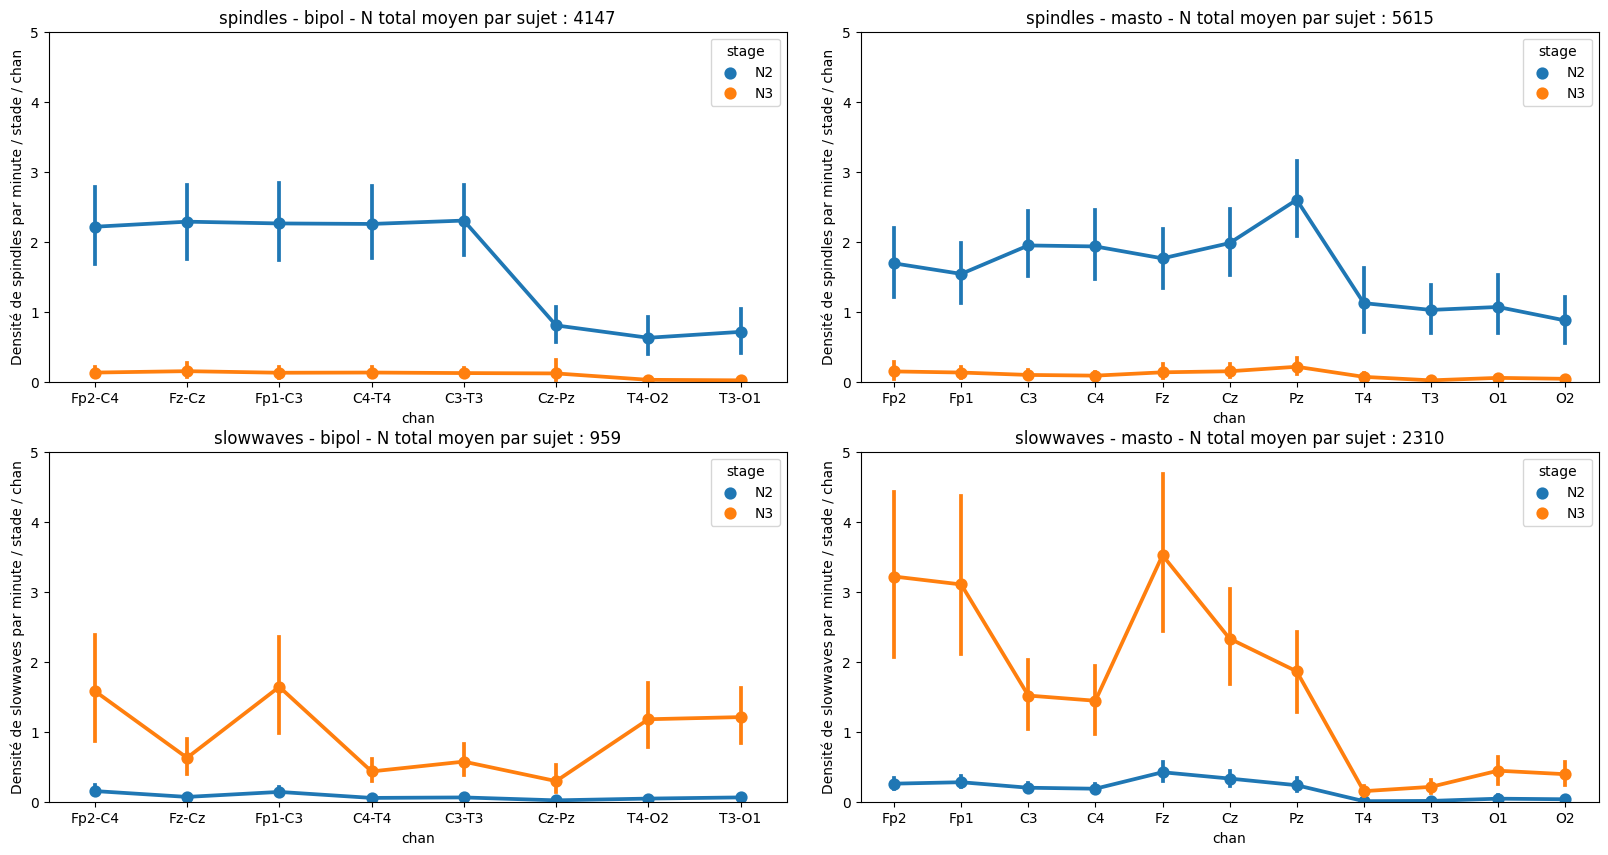

In [42]:
fig, axs = plt.subplots(nrows =2 , ncols = 2, figsize = (20,10))
fig.subplots_adjust(wspace = 0.1)
for r, ev in enumerate(evs):
    df_ev = df_spindles_comparison[df_spindles_comparison['event'] == ev]
    for c, mode in enumerate(['bipol','masto']): 
        ax = axs[r, c]
        N_mean = df_ev.groupby('mode').mean().loc[mode,'n_events_total']
        df_plot = df_ev[df_ev['mode'] == mode]
        sns.pointplot(data = df_plot , x = 'chan', y= 'density_by_stage_by_chan', hue = 'stage', ax=ax, order = mode_order[mode])
        ax.set_title(f'{ev} - {mode} - N total moyen par sujet : {int(N_mean)}')
        ax.set_ylim(0,5)
        ax.set_ylabel(f"Densité de {ev} par minute / stade / chan")

plt.savefig('../autres/ref_mode_events')

In [48]:
subject = 'S2'

In [6]:
sp_masto = pd.read_excel(f'../event_detection/S1_spindles_reref.xlsx', index_col = 0)
sp_bipol = pd.read_excel(f'../event_detection/S1_spindles.xlsx', index_col = 0)
sleep_stats = pd.read_excel(f'../subject_characteristics/global_sleep_stats.xlsx', index_col = 0)

In [4]:
sp_masto.shape

(6109, 15)

In [5]:
sp_bipol.shape

(4988, 15)

In [68]:
subject = 'S3'

In [74]:
input_file = glob.glob(f'../data/{subject}/*.edf')[0]
raw = mne.io.read_raw_edf(glob.glob(f'../data/{subject}/*.edf')[0], verbose = False, preload = False) # read in Volts
info = raw.info # info object

# get participant metadata
name = raw.__dict__['_raw_extras'][0]['subject_info']['name']

In [75]:
raw

<RawEDF | 181016G-A.edf, 33 x 9198336 (35931.0 s), ~36 kB, data not loaded>

In [92]:

start_meas = raw.info['meas_date']
secs = raw.__dict__['_raw_extras'][0]['n_records']
stop_meas = start_meas + datetime.timedelta(seconds=secs)

In [112]:
lights = pd.read_excel(f'../data/lights_timing.xlsx', index_col = 0)
rows = []
for subject in subjects:
    raw = mne.io.read_raw_edf(glob.glob(f'../data/{subject}/*.edf')[0], verbose = False, preload = False) # read in Volts
    start_meas = raw.info['meas_date']
    secs = raw.__dict__['_raw_extras'][0]['n_records']
    stop_meas = start_meas + datetime.timedelta(seconds=secs)
    light_on = lights.loc[subject, 'light_on'].strftime("%H:%M:%S")
    light_off = lights.loc[subject, 'light_off'].strftime("%H:%M:%S")
    rows.append([subject, start_meas.strftime("%H:%M:%S"), stop_meas.strftime("%H:%M:%S"), light_off, light_on])
lights_recordings = pd.DataFrame(rows, columns = ['subject','recording start time','recording stop time','light out', 'light on'])

In [128]:
datetime.datetime.strptime(lights_recordings.loc[0, 'recording start time'], "%H:%M:%S") - lights_recordings.loc[0, 'light on'])

TypeError: unsupported type for timedelta days component: datetime.time

In [135]:
datetime.datetime.strptime(lights_recordings.loc[0, 'recording start time'], "%H:%M:%S") - datetime.datetime.strptime(lights_recordings.loc[0, 'light on'].strftime("%H:%M:%S"),  "%H:%M:%S")

datetime.timedelta(seconds=54660)

In [133]:
datetime.datetime.strptime(lights_recordings.loc[0, 'light on'].strftime("%H:%M:%S"),  "%H:%M:%S")

datetime.datetime(1900, 1, 1, 7, 8, 37)

In [126]:
type(lights_recordings.loc[0, 'light on'])

datetime.time

In [127]:
type(datetime.datetime.strptime(lights_recordings.loc[0, 'recording start time'], "%H:%M:%S"))

datetime.datetime

In [114]:
lights_recordings.to_excel('../data/lights_recordings.xlsx')

In [ ]:
lights_recordings

In [20]:
annotations = pd.read_csv('../data/S9/190304A-Annotations', encoding = 'latin-1', sep = '\t', header = 1)

In [21]:
annotations

,Bloc,#,Temps écoulé,ms,Heure réelle,Durée,Annotation
0,0,1,00h00m00s,8 ms,20h12m13s,NaN,Début
1,0,2,00h00m02s,0 ms,20h12m15s,00:00:00,Assis
2,0,3,00h00m26s,0 ms,20h12m39s,00:00:00,Dorsal
3,0,4,00h00m29s,0 ms,20h12m42s,00:00:00,Latéral Droit
4,0,5,00h00m30s,0 ms,20h12m43s,00:00:00,Latéral Gauche
...,...,...,...,...,...,...,...
679,10,680,10h30m47s,555 ms,06h43m00s,00:00:04,Arousal d'origine respiratoire
680,10,681,10h34m12s,680 ms,06h46m25s,00:00:06,Arousal d'origine respiratoire
681,10,682,10h36m09s,551 ms,06h48m22s,00:00:10,Arousal d'origine respiratoire
682,10,683,10h37m57s,207 ms,06h50m10s,00:00:04,Arousal d'origine respiratoire


In [30]:
hypno_human = pd.read_csv('../data/S9/190304A-AhypnoEXP.txt', sep = '\t', header = None)

In [31]:
hypno_human

,0,1,2,3
0,30,00:00:30,W,1
1,60,00:01:00,W,1
2,90,00:01:30,W,1
3,120,00:02:00,W,1
4,150,00:02:30,W,1
...,...,...,...,...
1289,38670,10:44:30,N2,4
1290,38700,10:45:00,N2,4
1291,38730,10:45:30,N2,4
1292,38760,10:46:00,N2,4


In [2]:
patient = 'P1'

In [3]:
data = xr.load_dataarray(f'/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/preproc/{patient}.nc')
hypno = pd.read_excel(f'/crnldata/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/hypnos/hypno_{patient}.xlsx', index_col = 0)['yasa hypnogram'].values

In [4]:
pd.DataFrame.from_dict(yasa.sleep_statistics(yasa.hypno_str_to_int(hypno), sf_hyp=1/30), orient = 'index').T

,TIB,SPT,WASO,TST,N1,N2,N3,REM,NREM,SOL,...,Lat_N2,Lat_N3,Lat_REM,%N1,%N2,%N3,%REM,%NREM,SE,SME
0,529.5,439.0,31.0,408.0,31.0,199.0,58.0,120.0,288.0,54.0,...,57.5,70.0,125.0,7.598039,48.77451,14.215686,29.411765,70.588235,77.053824,92.938497


In [5]:
data

<xarray.DataArray (chan: 16, time: 8135680)>
array([[ 1.50529183e+02,  1.50191271e+02,  1.50805315e+02, ...,
         3.66188653e+01,  3.16137331e+01,  4.09883268e+01],
       [ 6.90894942e+01,  6.82894568e+01,  6.82945179e+01, ...,
         7.91938602e+01,  7.83772786e+01,  7.55330739e+01],
       [-6.08560311e+01, -5.40292796e+01, -5.20637536e+01, ...,
        -1.07113174e+02, -1.08970853e+02, -1.04350195e+02],
       ...,
       [ 3.50906615e+02,  4.32703797e+02,  5.63207479e+02, ...,
         6.00099189e+02,  7.06561343e+02,  7.57389105e+02],
       [-3.10902571e+06, -3.11244472e+06, -3.11953327e+06, ...,
        -9.76298840e+05, -9.86485334e+05, -1.01091020e+06],
       [ 3.46789883e+02,  3.48205014e+02,  3.52208052e+02, ...,
         4.29675266e+01,  3.85529983e+01,  4.10778210e+01]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.178e+04 3.178e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'EOGG' 'DEBIT' 'THERM'
Attributes:
    unit:     uV
    srate:    256.0

In [6]:
hypno.shape

(1059,)

In [7]:
sf_hypno = 1/30
hypno_upsample = yasa.hypno_upsample_to_data(hypno, sf_hypno, data, sf_data=srate, verbose=True)
hypno_upsampled_int = yasa.hypno_str_to_int(hypno_upsample)

21-Nov-22 20:27:59 | WARNING | Hypnogram is SHORTER than data by 10.00 seconds. Padding hypnogram with last value to match data.size.


In [8]:
data_eeg = data.sel(chan = eeg_chans)

In [9]:
data_eeg

<xarray.DataArray (chan: 8, time: 8135680)>
array([[ 150.52918288,  150.19127105,  150.80531456, ...,   36.6188653 ,
          31.61373306,   40.98832685],
       [  69.08949416,   68.28945681,   68.2945179 , ...,   79.19386016,
          78.3772786 ,   75.53307393],
       [ -60.85603113,  -54.02927956,  -52.06375356, ..., -107.11317359,
        -108.97085314, -104.35019455],
       ...,
       [ 238.77042802,  237.84142219,  235.8307037 , ...,  172.90292907,
         177.26691218,  177.55642023],
       [-219.43968872, -220.89509216, -219.46120471, ...,  -69.67244728,
         -67.33116472,  -68.37354086],
       [ 173.61867704,  176.77868483,  172.53304608, ...,   23.02490697,
          20.17191843,   22.73151751]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.178e+04 3.178e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'
Attributes:
    unit:     uV
    srate:    256.0

In [10]:
sp = yasa.spindles_detect(data=data_eeg, sf=srate, ch_names=eeg_chans, multi_only=False, remove_outliers=True, duration=(0.5, 2), min_distance=500, thresh={'corr': 0.8, 'rel_pow': 0.4, 'rms': 1.5}, hypno = hypno_upsampled_int, include = (0,1,2,3,4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.6s finished


In [11]:
sps = sp.summary()
mapper = {0:'W',1:'N1',2:'N2',3:'N3',4:'REM'}
sps['Stage_Letter'] = sps['Stage'].map(mapper)

In [12]:
sps['Stage_Letter'].value_counts()

N2     914
N3       3
N1       1
W        1
REM      1
Name: Stage_Letter, dtype: int64

In [13]:
sps

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter
0,3751.773438,3752.152344,3752.355469,0.582031,44.931074,11.038809,2.302837,0.562434,12.819284,7.0,0.646667,2,Fp2-C4,0,N2
1,3781.347656,3782.242188,3782.527344,1.179688,69.673285,13.270767,2.344561,0.641495,12.960701,15.0,0.755776,2,Fp2-C4,0,N2
2,3977.203125,3977.582031,3977.750000,0.546875,49.722653,13.873621,2.512609,0.582627,13.022612,7.0,0.687943,2,Fp2-C4,0,N2
3,4086.750000,4086.785156,4087.285156,0.535156,66.973174,15.769378,2.523259,0.547331,14.065248,7.0,0.065217,2,Fp2-C4,0,N2
4,4146.382812,4146.730469,4147.191406,0.808594,81.347117,18.013307,2.508374,0.478959,13.531399,10.0,0.427885,2,Fp2-C4,0,N2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,12565.855469,12566.179688,12566.464844,0.609375,60.882273,13.209732,2.286101,0.534287,13.876829,8.0,0.528662,2,T3-O1,7,N2
916,12798.925781,12799.328125,12799.441406,0.515625,70.301156,15.565172,2.538984,0.451823,14.440173,7.0,0.774436,2,T3-O1,7,N2
917,17570.722656,17571.042969,17571.656250,0.933594,86.572248,18.943881,2.694020,0.625506,14.119676,13.0,0.341667,2,T3-O1,7,N2
918,18090.109375,18090.304688,18090.902344,0.792969,41.454281,9.171116,1.906188,0.498988,13.894470,11.0,0.245098,2,T3-O1,7,N2


In [14]:
freq_sw = (0.3, 1.5) # Slow wave frequency range, in Hz
sw_dur_neg = (0.3, 1.5) # The minimum and maximum duration of the negative deflection of the slow wave, in secs
sw_dur_pos = (0.1, 1) # The minimum and maximum duration of the positive deflection of the slow wave, in secs
sw_dur_pos = (0.1, 1) # The minimum and maximum duration of the positive deflection of the slow wave, in secs
sw_amp_neg = (60,200) # Absolute minimum and maximum negative trough amplitude of the slow-wave. In µV
sw_amp_pos = (20,150) # Absolute minimum and maximum positive peak amplitude of the slow-wave. In µV
sw_amp_ptp = (85,350) # Minimum and maximum peak-to-peak amplitude of the slow-wave. In µV

In [15]:
sw = yasa.sw_detect(data=data_eeg, sf=srate, ch_names=eeg_chans, hypno=hypno_upsampled_int, include=(0,1,2,3,4), freq_sw=freq_sw, dur_neg=sw_dur_neg, dur_pos=sw_dur_pos, amp_neg=sw_amp_neg, amp_pos=sw_amp_neg, amp_ptp=sw_amp_ptp, coupling=True, remove_outliers=True, verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.4s finished


In [16]:
sws = sw.summary()

In [17]:
sws['Stage_Letter'] = sws['Stage'].map(mapper)

In [18]:
sws

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter
0,40.796875,41.089844,41.671875,42.027344,42.300781,1.5039,-127.592093,104.165656,231.757749,398.187810,0.664938,41.847656,-0.961795,0.254619,0,Fp2-C4,0,W
1,46.718750,47.070312,47.351562,47.574219,48.253906,1.5352,-152.414061,91.900104,244.314165,868.672586,0.651381,47.457031,-1.021984,0.180842,0,Fp2-C4,0,W
2,51.574219,51.828125,52.050781,52.238281,52.433594,0.8594,-96.525581,70.402588,166.928169,749.712476,1.163603,52.179688,-0.680382,0.392585,0,Fp2-C4,0,W
3,64.417969,64.738281,65.019531,65.246094,65.609375,1.1914,-105.438001,63.183263,168.621264,599.542272,0.839349,64.402344,1.484368,0.126504,0,Fp2-C4,0,W
4,611.187500,611.531250,611.839844,612.191406,612.585938,1.3984,-87.696269,133.952406,221.648675,718.253934,0.715103,611.894531,-1.322108,0.308584,0,Fp2-C4,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,20657.199219,20657.488281,20657.742188,20657.964844,20658.300781,1.1016,-98.461181,71.113752,169.574934,667.864354,0.907771,20656.773438,-2.654438,0.366818,2,T3-O1,7,N2
757,22911.925781,22912.246094,22912.480469,22912.796875,22913.113281,1.1875,-65.114769,108.210941,173.325711,739.523032,0.842105,22911.683594,1.094696,0.295158,4,T3-O1,7,REM
758,26052.515625,26052.843750,26053.136719,26053.500000,26053.949219,1.4336,-74.815440,68.163297,142.978737,488.034090,0.697545,26053.117188,-1.658658,0.221455,2,T3-O1,7,N2
759,26055.234375,26055.476562,26055.707031,26055.925781,26056.269531,1.0352,-81.997451,62.850192,144.847642,628.491465,0.965997,26054.742188,-2.265879,0.369293,2,T3-O1,7,N2


In [19]:
sws.shape

(761, 18)

In [20]:
sws

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter
0,40.796875,41.089844,41.671875,42.027344,42.300781,1.5039,-127.592093,104.165656,231.757749,398.187810,0.664938,41.847656,-0.961795,0.254619,0,Fp2-C4,0,W
1,46.718750,47.070312,47.351562,47.574219,48.253906,1.5352,-152.414061,91.900104,244.314165,868.672586,0.651381,47.457031,-1.021984,0.180842,0,Fp2-C4,0,W
2,51.574219,51.828125,52.050781,52.238281,52.433594,0.8594,-96.525581,70.402588,166.928169,749.712476,1.163603,52.179688,-0.680382,0.392585,0,Fp2-C4,0,W
3,64.417969,64.738281,65.019531,65.246094,65.609375,1.1914,-105.438001,63.183263,168.621264,599.542272,0.839349,64.402344,1.484368,0.126504,0,Fp2-C4,0,W
4,611.187500,611.531250,611.839844,612.191406,612.585938,1.3984,-87.696269,133.952406,221.648675,718.253934,0.715103,611.894531,-1.322108,0.308584,0,Fp2-C4,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,20657.199219,20657.488281,20657.742188,20657.964844,20658.300781,1.1016,-98.461181,71.113752,169.574934,667.864354,0.907771,20656.773438,-2.654438,0.366818,2,T3-O1,7,N2
757,22911.925781,22912.246094,22912.480469,22912.796875,22913.113281,1.1875,-65.114769,108.210941,173.325711,739.523032,0.842105,22911.683594,1.094696,0.295158,4,T3-O1,7,REM
758,26052.515625,26052.843750,26053.136719,26053.500000,26053.949219,1.4336,-74.815440,68.163297,142.978737,488.034090,0.697545,26053.117188,-1.658658,0.221455,2,T3-O1,7,N2
759,26055.234375,26055.476562,26055.707031,26055.925781,26056.269531,1.0352,-81.997451,62.850192,144.847642,628.491465,0.965997,26054.742188,-2.265879,0.369293,2,T3-O1,7,N2


In [21]:
sws['Channel'].value_counts()

T4-O2     192
T3-O1     156
Fp2-C4    120
C3-T3      95
Fp1-C3     88
C4-T4      53
Fz-Cz      40
Cz-Pz      17
Name: Channel, dtype: int64

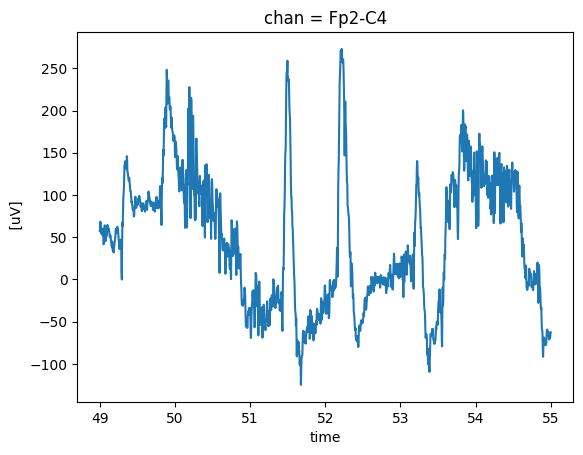

In [22]:
data.loc['Fp2-C4',49:55].plot()

In [23]:
%matplotlib widget

In [ ]:
t_keep.shape

In [ ]:
start = 35
stop = 75

neg_peaks_times = sws['NegPeak'].values
keep_peaks = (neg_peaks_times > start) & (neg_peaks_times < stop)
t_sw = neg_peaks_times[keep_peaks]
print(t_sw)

t = data.coords['time'].values
t_mask = (t> start) & (t < stop)
sig = data.loc['Fp2-C4',:].values
t_sig = t[t_mask]
sig_keep = sig[t_mask]

y_sw = sig[np.isin(t, t_sw)]

fig, ax = plt.subplots()
ax.plot(t_sig, sig_keep)
ax.plot(t_sw, y_sw, 'o')
plt.show()

In [ ]:
y_sw

In [28]:
test = xr.load_dataarray(f'../sigma_power/P14_sigma_power.nc')

In [31]:
test

<xarray.DataArray (chan: 2, freq: 10, time: 9850368)>
array([[[1.27601536e+03, 1.26921750e+03, 1.26349848e+03, ...,
         3.07525890e+05, 3.09439216e+05, 3.10962931e+05],
        [5.07990603e+02, 4.68123637e+02, 4.27986606e+02, ...,
         2.68594185e+05, 2.70426957e+05, 2.71872734e+05],
        [1.25773864e+03, 1.25354713e+03, 1.24889719e+03, ...,
         2.46337222e+05, 2.47801832e+05, 2.48875239e+05],
        ...,
        [9.13217132e+02, 9.20457671e+02, 9.26656802e+02, ...,
         1.39676126e+05, 1.41290961e+05, 1.42518313e+05],
        [5.13630495e+02, 5.02120639e+02, 4.89710261e+02, ...,
         1.29230395e+05, 1.30747991e+05, 1.31877491e+05],
        [3.29998190e+02, 3.07170102e+02, 2.83379291e+02, ...,
         1.22574280e+05, 1.23801846e+05, 1.24649549e+05]],

       [[1.07225168e+05, 1.06739104e+05, 1.06104439e+05, ...,
         5.21476638e+05, 5.23479100e+05, 5.24851941e+05],
        [1.05507795e+05, 1.05352446e+05, 1.05045012e+05, ...,
         4.53541463e+05, 4.55781409e+05, 4.57381541e+05],
        [1.05542450e+05, 1.05767369e+05, 1.05835992e+05, ...,
         4.06974708e+05, 4.09000707e+05, 4.10378824e+05],
        ...,
        [7.15535986e+04, 7.20435237e+04, 7.23607586e+04, ...,
         2.21652518e+05, 2.24193162e+05, 2.26123200e+05],
        [6.20536878e+04, 6.24203746e+04, 6.26211733e+04, ...,
         2.05621571e+05, 2.07982138e+05, 2.09734198e+05],
        [5.31451747e+04, 5.33526130e+04, 5.33987639e+04, ...,
         1.94562915e+05, 1.96582192e+05, 1.97996613e+05]]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.848e+04 3.848e+04
  * freq     (freq) float64 10.0 10.67 11.33 12.0 ... 14.0 14.67 15.33 16.0
  * chan     (chan) object 'Fp2-C4' 'Fp1-C3'

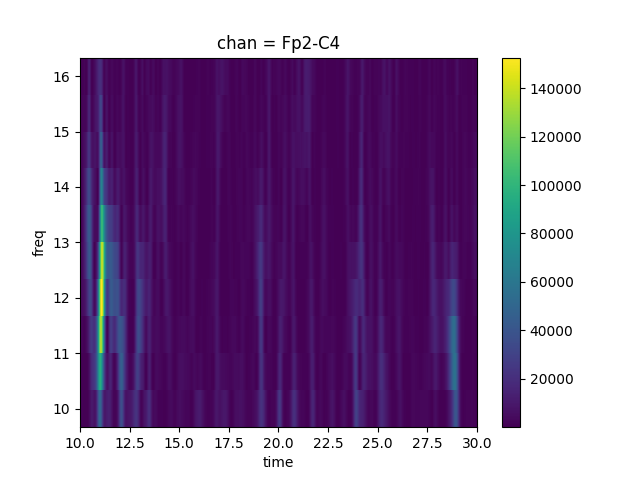

In [33]:
test.loc['Fp2-C4',:,10:30].plot()

In [28]:
del da

In [3]:
da = xr.open_dataarray(f'../sigma_power/{patient}_sigma_power.nc')

In [4]:
da

<xarray.DataArray (chan: 8, freq: 30, time: 8135680)>
[1952563200 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 3.178e+04 3.178e+04
  * freq     (freq) float64 10.0 10.21 10.41 10.62 ... 15.38 15.59 15.79 16.0
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'Fp1-C3' 'C3-T3' 'T3-O1'

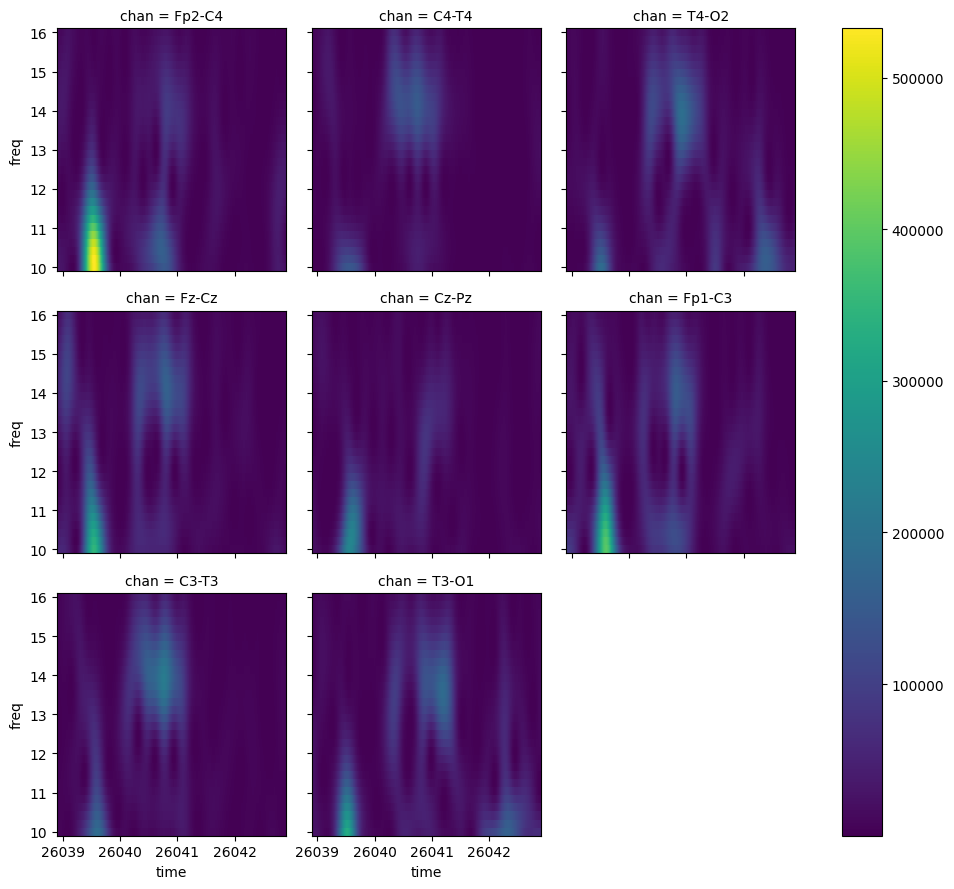

In [12]:
timing = 26040.9
wsize = 2
start = timing - wsize
stop = timing + wsize
da.loc[:,:,start:stop].plot.pcolormesh(x = 'time', y = 'freq', row = 'chan', col_wrap = 3)